# Mixture of Experts (MoE) Analysis

**Goal**: Deep dive into MoE architectures in the ecosystem.

**Key Questions**:
1. What's the MoE adoption rate?
2. What expert configurations are common?
3. Which organizations lead MoE development?
4. How do MoE models differ from dense models?

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Style matching main repo
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [9]:
df = pd.read_csv('data/model_configs_expanded.csv', low_memory=False)

# Convert numeric columns to proper numeric types
numeric_cols = [
    'config_n_routed_experts', 'config_num_experts_per_tok', 'config_n_shared_experts',
    'config_moe_intermediate_size', 'config_moe_expert_utilization',
    'config_hidden_size', 'config_num_hidden_layers', 'config_max_position_embeddings',
    'config_gqa_ratio'
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert boolean columns
bool_cols = [c for c in df.columns if c.startswith('is_') or c.startswith('uses_')]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].map({'True': True, 'False': False, True: True, False: False, 'true': True, 'false': False})

# Extract organization
df['organization'] = df['modelId'].apply(lambda x: str(x).split('/')[0] if pd.notna(x) and '/' in str(x) else 'community')

print(f"Total models: {len(df):,}")

Total models: 14,557


## 1. MoE Adoption Overview

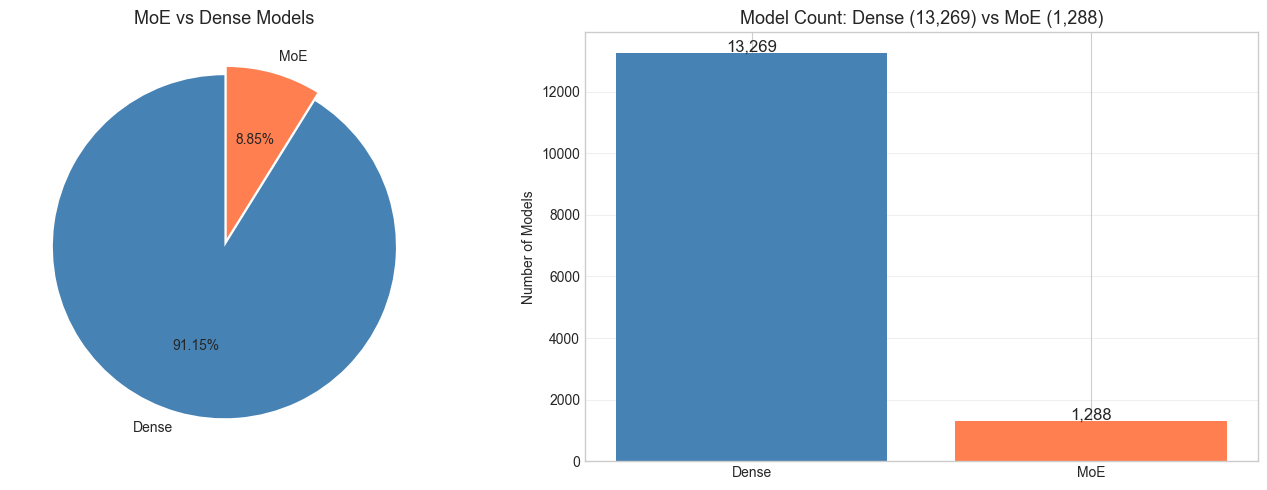


MoE adoption rate: 8.85%


In [10]:
moe_count = (df['uses_moe'] == True).sum()
dense_count = len(df) - moe_count

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie([dense_count, moe_count], labels=['Dense', 'MoE'], 
            autopct='%1.2f%%', colors=['steelblue', 'coral'],
            explode=[0, 0.05], startangle=90)
axes[0].set_title('MoE vs Dense Models', fontsize=13)

# Bar chart with counts
axes[1].bar(['Dense', 'MoE'], [dense_count, moe_count], color=['steelblue', 'coral'])
axes[1].set_ylabel('Number of Models')
axes[1].set_title(f'Model Count: Dense ({dense_count:,}) vs MoE ({moe_count:,})', fontsize=13)
axes[1].grid(True, alpha=0.3, axis='y')

# Add count labels
for i, count in enumerate([dense_count, moe_count]):
    axes[1].text(i, count + 50, f'{count:,}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('figures/moe_adoption.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMoE adoption rate: {moe_count/len(df)*100:.2f}%")

## 2. MoE Models Deep Dive

In [ ]:
# Filter to MoE models (if not already defined)
if 'df_moe' not in locals():
    df_moe = df[df['uses_moe'] == True].copy()

# Most common routed expert counts
experts = pd.to_numeric(df_moe['config_n_routed_experts'], errors='coerce').dropna()

if len(experts) > 0:
    experts_int = experts.astype(int)
    expert_counts = experts_int.value_counts().sort_index()
    
    # Bar chart for most common counts
    top_experts = expert_counts.head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.barh(range(len(top_experts)), top_experts.values, color='coral', alpha=0.8)
    ax.set_yticks(range(len(top_experts)))
    ax.set_yticklabels([f'{int(x)} experts' for x in top_experts.index])
    ax.invert_yaxis()
    ax.set_xlabel('Count', fontsize=11)
    ax.set_title('Most Common Expert Counts', fontsize=13)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (idx, val) in enumerate(zip(top_experts.index, top_experts.values)):
        ax.text(val + 0.5, i, str(val), va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('figures/most_common_expert_counts.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nMost common routed expert counts:")
    print(expert_counts.head(10))

In [11]:
# Filter to MoE models
df_moe = df[df['uses_moe'] == True].copy()
print(f"MoE models: {len(df_moe):,}")

# Available MoE fields
moe_cols = [c for c in df_moe.columns if 'moe' in c.lower() or 'expert' in c.lower() or 'routed' in c.lower()]
print("\nMoE-related columns:")
for col in moe_cols:
    non_null = df_moe[col].notna().sum()
    print(f"  {col}: {non_null} non-null")

MoE models: 1,288

MoE-related columns:
  uses_moe: 1288 non-null
  config_moe_enabled: 168 non-null
  config_moe_expert_utilization: 34 non-null
  config_moe_intermediate_size: 54 non-null
  config_moe_layer_freq: 44 non-null
  config_n_routed_experts: 38 non-null
  config_n_shared_experts: 38 non-null
  config_num_experts_per_tok: 92 non-null
  config_routed_scaling_factor: 36 non-null


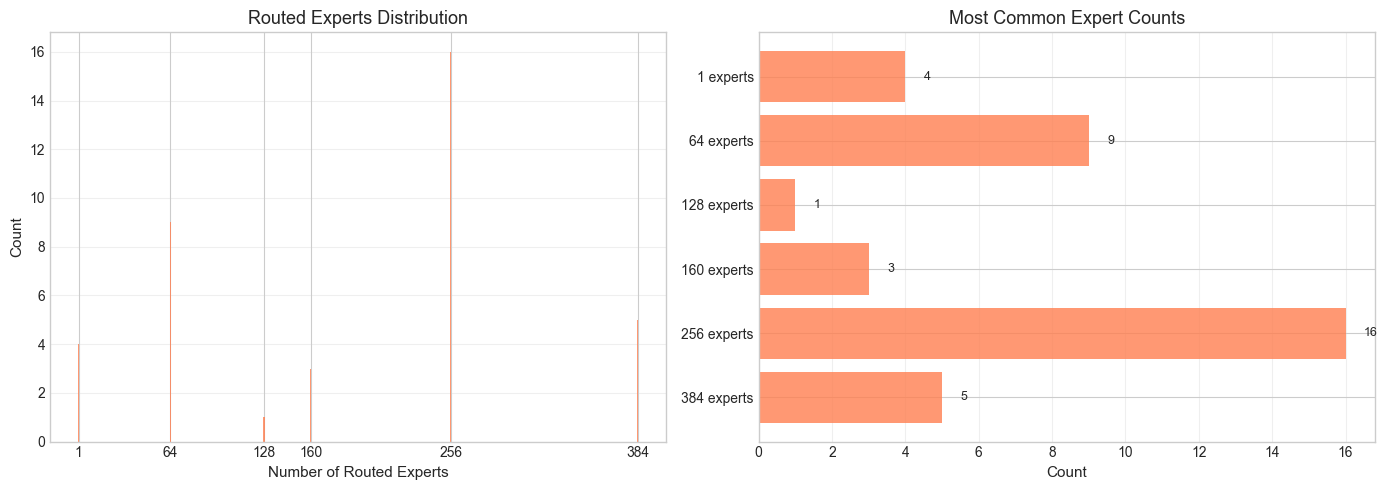


Most common routed expert counts:
config_n_routed_experts
1       4
64      9
128     1
160     3
256    16
384     5
Name: count, dtype: int64


In [12]:
# Number of routed experts distribution - histogram
experts = pd.to_numeric(df_moe['config_n_routed_experts'], errors='coerce').dropna()

if len(experts) > 0:
    # Convert to int for histogram
    experts_int = experts.astype(int)
    
    # Create histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(experts_int, bins=30, color='coral', edgecolor='white', alpha=0.8)
    ax.set_xlabel('Number of Routed Experts', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title('Routed Experts Distribution', fontsize=13)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('figures/routed_experts_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nRouted experts statistics:")
    print(f"  Min: {experts_int.min()}")
    print(f"  Max: {experts_int.max()}")
    print(f"  Median: {experts_int.median():.0f}")
    print(f"  Mean: {experts_int.mean():.1f}")

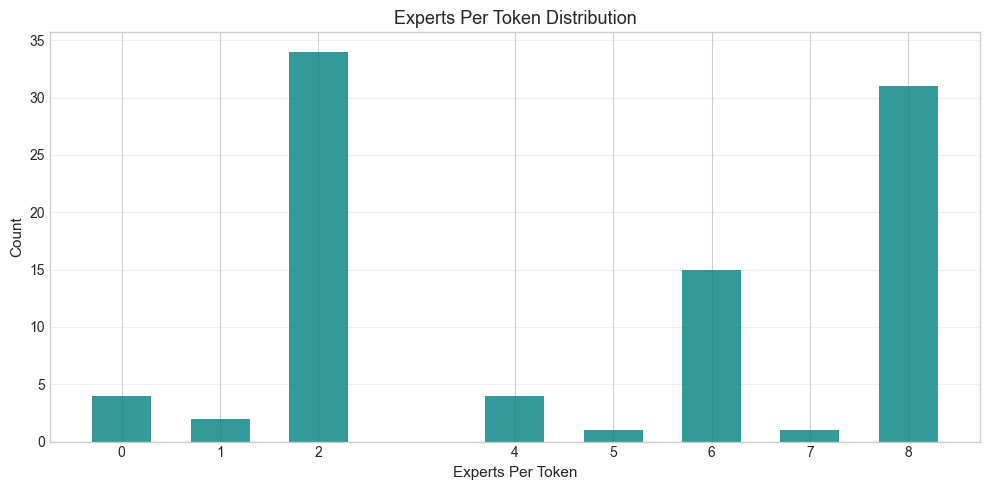


Experts per token distribution:
config_num_experts_per_tok
0     4
1     2
2    34
4     4
5     1
6    15
7     1
8    31
Name: count, dtype: int64


In [13]:
# Experts per token distribution
experts_per_tok = pd.to_numeric(df_moe['config_num_experts_per_tok'], errors='coerce').dropna()

if len(experts_per_tok) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    experts_per_tok_int = experts_per_tok.astype(int)
    tok_counts = experts_per_tok_int.value_counts().sort_index()
    
    x_pos = tok_counts.index.values
    ax.bar(x_pos, tok_counts.values, color='teal', alpha=0.8, width=0.6)
    ax.set_xlabel('Experts Per Token', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title('Experts Per Token Distribution', fontsize=13)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_pos)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('figures/experts_per_token.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nExperts per token distribution:")
    print(tok_counts)

## 3. Expert Utilization Analysis

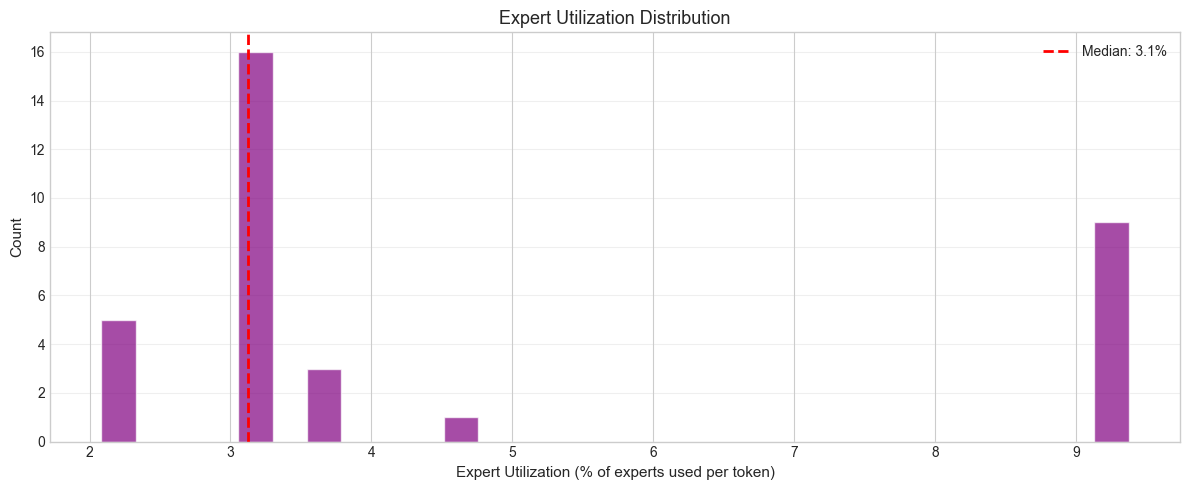


Expert utilization statistics:
  Median: 3.12%
  Mean: 4.73%
  Range: [2.08%, 9.38%]


In [14]:
# Calculate expert utilization - handle concatenated strings
# First try direct conversion, if that fails, compute from experts_per_tok / n_routed_experts
util_raw = pd.to_numeric(df_moe['config_moe_expert_utilization'], errors='coerce')

# If we have valid utilization values, use them
# Otherwise compute from experts_per_tok and n_routed_experts
if util_raw.notna().sum() > 0 and util_raw.max() <= 1.0:
    util = util_raw.dropna() * 100  # Convert to percentage
else:
    # Compute utilization from experts_per_tok / n_routed_experts
    experts_per_tok_clean = pd.to_numeric(df_moe['config_num_experts_per_tok'], errors='coerce')
    experts_clean = pd.to_numeric(df_moe['config_n_routed_experts'], errors='coerce')
    
    # Only compute where both are available
    mask = experts_per_tok_clean.notna() & experts_clean.notna() & (experts_clean > 0)
    util = (experts_per_tok_clean[mask] / experts_clean[mask] * 100).dropna()

if len(util) > 0:
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.hist(util, bins=30, color='purple', alpha=0.7, edgecolor='white')
    median_val = util.median()
    ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}%')
    ax.set_xlabel('Expert Utilization (% of experts used per token)', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title('Expert Utilization Distribution', fontsize=13)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('figures/expert_utilization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nExpert utilization statistics:")
    print(f"  Median: {median_val:.2f}%")
    print(f"  Mean: {util.mean():.2f}%")
    print(f"  Range: [{util.min():.2f}%, {util.max():.2f}%]")
else:
    print("\nNo valid expert utilization data available")

## 4. Organizations Leading MoE Development

In [ ]:
# Top organizations with MoE models
moe_orgs = df_moe['organization'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.magma(np.linspace(0.2, 0.9, len(moe_orgs)))
bars = ax.barh(range(len(moe_orgs)), moe_orgs.values, color=colors)
ax.set_yticks(range(len(moe_orgs)))
ax.set_yticklabels(moe_orgs.index)
ax.invert_yaxis()
ax.set_xlabel('Number of MoE Models', fontsize=11)
ax.set_title('Top Organizations: MoE Model Development', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, moe_orgs.values):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, str(val), va='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/moe_by_organization.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. MoE vs Dense Model Comparison

In [ ]:
# Compare key parameters between MoE and Dense models
df['model_type'] = df['uses_moe'].map({True: 'MoE', False: 'Dense'})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hidden Size
df_plot = df[df['config_hidden_size'].notna()]
moe_data = df_plot[df_plot['model_type'] == 'MoE']['config_hidden_size'].dropna()
dense_data = df_plot[df_plot['model_type'] == 'Dense']['config_hidden_size'].dropna()
axes[0,0].boxplot([dense_data, moe_data], labels=['Dense', 'MoE'])
axes[0,0].set_title('Hidden Size: MoE vs Dense', )
axes[0,0].set_ylabel('Hidden Size')
axes[0,0].grid(True, alpha=0.3, axis='y')

# Number of Layers
df_plot = df[df['config_num_hidden_layers'].notna()]
moe_data = df_plot[df_plot['model_type'] == 'MoE']['config_num_hidden_layers'].dropna()
dense_data = df_plot[df_plot['model_type'] == 'Dense']['config_num_hidden_layers'].dropna()
axes[0,1].boxplot([dense_data, moe_data], labels=['Dense', 'MoE'])
axes[0,1].set_title('Number of Layers: MoE vs Dense', )
axes[0,1].set_ylabel('Number of Layers')
axes[0,1].grid(True, alpha=0.3, axis='y')

# Context Length (log scale)
df_plot = df[df['config_max_position_embeddings'].notna()]
moe_data = df_plot[df_plot['model_type'] == 'MoE']['config_max_position_embeddings'].dropna()
dense_data = df_plot[df_plot['model_type'] == 'Dense']['config_max_position_embeddings'].dropna()
axes[1,0].boxplot([dense_data, moe_data], labels=['Dense', 'MoE'])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Context Length (log): MoE vs Dense', )
axes[1,0].set_ylabel('Context Length')
axes[1,0].grid(True, alpha=0.3, axis='y')

# GQA Ratio
df_plot = df[df['config_gqa_ratio'].notna()]
moe_data = df_plot[df_plot['model_type'] == 'MoE']['config_gqa_ratio'].dropna()
dense_data = df_plot[df_plot['model_type'] == 'Dense']['config_gqa_ratio'].dropna()
axes[1,1].boxplot([dense_data, moe_data], labels=['Dense', 'MoE'])
axes[1,1].set_title('GQA Ratio: MoE vs Dense', )
axes[1,1].set_ylabel('GQA Ratio')
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.suptitle('MoE vs Dense Architecture Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('figures/moe_vs_dense_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. MoE Configuration Patterns

In [ ]:
# Explore common MoE configurations
df_moe_sig = df_moe[['modelId', 'config_n_routed_experts', 'config_num_experts_per_tok']].copy()
df_moe_sig['config_n_routed_experts'] = pd.to_numeric(df_moe_sig['config_n_routed_experts'], errors='coerce')
df_moe_sig['config_num_experts_per_tok'] = pd.to_numeric(df_moe_sig['config_num_experts_per_tok'], errors='coerce')
df_moe_sig = df_moe_sig.dropna()

if len(df_moe_sig) > 0:
    df_moe_sig['config'] = df_moe_sig.apply(
        lambda x: f"{int(x['config_n_routed_experts'])} experts, {int(x['config_num_experts_per_tok'])} active", 
        axis=1
    )
    
    # Most common configurations
    config_counts = df_moe_sig['config'].value_counts().head(10)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(range(len(config_counts)), config_counts.values, color='mediumpurple', alpha=0.8)
    ax.set_yticks(range(len(config_counts)))
    ax.set_yticklabels(config_counts.index)
    ax.invert_yaxis()
    ax.set_xlabel('Count', fontsize=11)
    ax.set_title('Most Common MoE Configurations', fontsize=14)
    ax.grid(True, alpha=0.3, axis='x')
    
    for bar, val in zip(bars, config_counts.values):
        ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, str(val), va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('figures/moe_configurations.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No MoE configuration data available")

## 7. MoE Model Examples

In [ ]:
# Show sample MoE models with their configurations
sample_cols = ['modelId', 'config_model_type', 'config_hidden_size', 'config_num_hidden_layers',
               'config_n_routed_experts', 'config_num_experts_per_tok', 'config_n_shared_experts']

sample = df_moe[sample_cols].dropna(subset=['config_n_routed_experts']).head(15)
print("\nSample MoE Models:")
print("="*120)
print(sample.to_string(index=False))

## 8. MoE Summary Statistics

In [ ]:
print("="*80)
print("MOE ANALYSIS SUMMARY")
print("="*80)

print(f"\n📊 OVERALL")
print(f"   Total MoE models: {len(df_moe):,}")
print(f"   MoE adoption rate: {len(df_moe)/len(df)*100:.2f}%")

print(f"\n🔧 COMMON CONFIGURATIONS")
experts_clean = pd.to_numeric(df_moe['config_n_routed_experts'], errors='coerce').dropna()
experts_per_tok_clean = pd.to_numeric(df_moe['config_num_experts_per_tok'], errors='coerce').dropna()

if len(experts_clean) > 0:
    mode_val = experts_clean.mode().iloc[0] if len(experts_clean.mode()) > 0 else None
    if mode_val is not None:
        print(f"   Most common routed experts: {int(mode_val)} ({(experts_clean == mode_val).sum()} models)")

if len(experts_per_tok_clean) > 0:
    mode_val = experts_per_tok_clean.mode().iloc[0] if len(experts_per_tok_clean.mode()) > 0 else None
    if mode_val is not None:
        print(f"   Most common experts per token: {int(mode_val)} ({(experts_per_tok_clean == mode_val).sum()} models)")

print(f"\n🏢 TOP CONTRIBUTORS")
for org, count in moe_orgs.head(5).items():
    print(f"   {org}: {count} models")

# Save summary
most_common_experts = 'N/A'
most_common_per_tok = 'N/A'
if len(experts_clean) > 0 and len(experts_clean.mode()) > 0:
    most_common_experts = int(experts_clean.mode().iloc[0])
if len(experts_per_tok_clean) > 0 and len(experts_per_tok_clean.mode()) > 0:
    most_common_per_tok = int(experts_per_tok_clean.mode().iloc[0])

moe_summary = {
    'metric': ['total_moe', 'adoption_rate', 'most_common_experts', 'most_common_per_tok'],
    'value': [len(df_moe), f'{len(df_moe)/len(df)*100:.2f}%', most_common_experts, most_common_per_tok]
}
pd.DataFrame(moe_summary).to_csv('moe_summary.csv', index=False)
print("\n✓ Summary saved to moe_summary.csv")